In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import sys
!pip install rdkit
import pandas as pd
from rdkit import Chem
import os
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from rdkit.Avalon import pyAvalonTools
from tqdm import tqdm

from sklearn.metrics import *
import matplotlib.pyplot as plt
import warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df_chembl = pd.read_csv('Drug_Resistance_CHEMBL4026_Signal_transducer_and_activator_of_transcription.csv')
df_chembl = df_chembl[['Smiles', 'Standard Type', 'Standard Value']]
df_bdb = pd.read_csv("Drug_Resistance_BDB_Signal_transducer_and_activator_of_transcription.csv")
target_for_bdb = 'IC50 (nM)'
target_for_chembl = 'IC50'
df_bdb = df_bdb[['Ligand SMILES', target_for_bdb]]
df_chembl = df_chembl.loc[df_chembl['Standard Type'] == target_for_chembl]
df_chembl = df_chembl.drop(['Standard Type'], axis=1)

In [ ]:
df_bdb = df_bdb.rename(columns={'Ligand SMILES': 'Smiles', target_for_bdb: 'Standard Value'})

In [ ]:
df = pd.concat([df_chembl, df_bdb], ignore_index=True)
df['Standard Value'] = df['Standard Value'].replace(to_replace='>', value='', regex=True)
df['Standard Value']= df['Standard Value'].replace(to_replace='<', value='', regex=True)
df['Standard Value'] = pd.to_numeric(df['Standard Value'])
df = df.dropna()
df

,Smiles,Standard Value
0,O=S(=O)(Nc1cc(Cl)cc(Cl)c1)c1cc(Cl)cc(Cl)c1O,2300.00
1,CC(C)(C)c1cc(NS(=O)(=O)c2cc(Cl)cc(Cl)c2O)cc(C(...,1100.00
2,O=C(OC/C=C\c1ccccc1)c1ccccc1NS(=O)(=O)c1cc(Cl)...,340.00
3,O=S(=O)(Nc1c(-c2ccccc2)cc(-c2ccccc2)cc1-c1cccc...,190.00
4,O=C(O)C[C@@](O)(C[C@H](O)CCCCCCc1ccc(Cl)cc1Cl)...,2100.00
...,...,...
865,Oc1c(Cl)cc(Br)cc1S(=O)(=O)n1c(cc2cc(ccc12)C#N)...,10250.00
866,Oc1c(Cl)cc(Br)cc1S(=O)(=O)n1c(cc2cc(Cl)ccc12)C...,10250.00
867,Oc1c(Cl)cc(Br)cc1S(=O)(=O)n1cc(C(=O)N2CCC2)c2c...,10250.00
868,CCOC(=O)c1cc2cc(Cl)ccc2n1S(=O)(=O)c1ccc(cc1F)-...,20000.00


In [ ]:
q3 = df['Standard Value'].quantile(0.75)
df = df[df['Standard Value'] <= q3]
df['Standard Value'].describe()
df['Standard Value'].median()

10250.0

In [ ]:
threshold = df['Standard Value'].median()
df["Blinding"] = df["Standard Value"].apply(lambda x: 1 if x>=threshold else 0)

In [ ]:
def safe_canon_smiles(smiles):
    try:
        return Chem.CanonSmiles(smiles)
    except Exception as e:
        print(f"Bad Smiles: {smiles}")
        return None
df['Smiles'] = df['Smiles'].astype('string')
df['Canonical Smiles'] = df.Smiles.apply(safe_canon_smiles)
df

Bad Smiles: Oc1c(Cl)cc(Cl)cc1S(=O)(=O)Nc1cc(ccc1F)-c1nn[nH][nH]1
Bad Smiles: COc1ccc(cc1NS(=O)(=O)c1cc(cc(Cl)c1OC)C(O)=O)-c1ccc[nH]c1
Bad Smiles: Cn1[nH]cc(c1NS(=O)(=O)c1cc(Cl)cc(Cl)c1O)-c1ccccc1
Bad Smiles: COc1ccc(cc1NS(=O)(=O)c1cc(cc(Cl)c1O)C(=O)N1CCC1)-c1ccc[nH]c1
Bad Smiles: Oc1c(Cl)cc(Cl)cc1S(=O)(=O)Nc1cc(ccc1F)-n1n[nH]nc1C1CC1
Bad Smiles: Oc1c(Cl)cc(cc1S(=O)(=O)Nc1cc(ccc1F)-c1cc[nH]cc1)C(=O)N1CCC1
Bad Smiles: OC(=O)c1[nH]cc(cc1NS(=O)(=O)c1cc(Cl)cc(Cl)c1)-c1ccccc1
Bad Smiles: Oc1c(F)cc(F)cc1S(=O)(=O)n1c(cc2cc(Cl)ccc12)C1=C[N]([O-])=CC=C1


,Smiles,Standard Value,Blinding,Canonical Smiles
0,O=S(=O)(Nc1cc(Cl)cc(Cl)c1)c1cc(Cl)cc(Cl)c1O,2300.00,0,O=S(=O)(Nc1cc(Cl)cc(Cl)c1)c1cc(Cl)cc(Cl)c1O
1,CC(C)(C)c1cc(NS(=O)(=O)c2cc(Cl)cc(Cl)c2O)cc(C(...,1100.00,0,CC(C)(C)c1cc(NS(=O)(=O)c2cc(Cl)cc(Cl)c2O)cc(C(...
2,O=C(OC/C=C\c1ccccc1)c1ccccc1NS(=O)(=O)c1cc(Cl)...,340.00,0,O=C(OC/C=C\c1ccccc1)c1ccccc1NS(=O)(=O)c1cc(Cl)...
3,O=S(=O)(Nc1c(-c2ccccc2)cc(-c2ccccc2)cc1-c1cccc...,190.00,0,O=S(=O)(Nc1c(-c2ccccc2)cc(-c2ccccc2)cc1-c1cccc...
4,O=C(O)C[C@@](O)(C[C@H](O)CCCCCCc1ccc(Cl)cc1Cl)...,2100.00,0,O=C(O)C[C@@](O)(C[C@H](O)CCCCCCc1ccc(Cl)cc1Cl)...
...,...,...,...,...
864,Cc1cc2cc(Cl)c(cc2n1S(=O)(=O)c1cc(Br)cc(Cl)c1O)...,10250.00,1,Cc1cc2cc(Cl)c(C(=O)O)cc2n1S(=O)(=O)c1cc(Br)cc(...
865,Oc1c(Cl)cc(Br)cc1S(=O)(=O)n1c(cc2cc(ccc12)C#N)...,10250.00,1,N#Cc1ccc2c(c1)cc(-c1cc3ccccc3s1)n2S(=O)(=O)c1c...
866,Oc1c(Cl)cc(Br)cc1S(=O)(=O)n1c(cc2cc(Cl)ccc12)C...,10250.00,1,O=C(c1cc2cc(Cl)ccc2n1S(=O)(=O)c1cc(Br)cc(Cl)c1...
867,Oc1c(Cl)cc(Br)cc1S(=O)(=O)n1cc(C(=O)N2CCC2)c2c...,10250.00,1,O=C(c1cn(S(=O)(=O)c2cc(Br)cc(Cl)c2O)c2ccc(Cl)c...


In [ ]:
df.replace('None', pd.NA, inplace=True)
df.dropna(inplace=True)
df.drop(['Smiles'], axis=1, inplace=True)
df

,Standard Value,Blinding,Canonical Smiles
3,9.40,1,CCOc1ncc(C(=O)Nc2ccc(OC(F)(F)F)cc2)cc1-c1cncnc1
5,430.00,1,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc...
7,410.00,1,Nc1[nH]cnc2nnc(Nc3cccc(Cl)c3)c1-2
8,73.00,1,CC(C)(C)c1cc(NC(=O)Nc2ccc(Nc3ncnc4ccc(N)cc34)c...
10,130.00,1,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1N1Cc2cnc(Nc...
...,...,...,...
4275,200.00,1,Nc1ncnc2c1c(-c1ccccc1)cn2-c1cccc(CO)c1
4276,18.00,1,Nc1ncnc2c1c(-c1cnc3[nH]ccc3c1)nn2C1CCCC1
4277,0.80,0,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...
4278,1.10,0,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...


In [ ]:
print(df.duplicated(subset='Canonical Smiles').sum())
df.drop_duplicates(inplace=True, keep = 'first', subset='Canonical Smiles')
df

1189


,Standard Value,Blinding,Canonical Smiles
3,9.40,1,CCOc1ncc(C(=O)Nc2ccc(OC(F)(F)F)cc2)cc1-c1cncnc1
5,430.00,1,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc...
7,410.00,1,Nc1[nH]cnc2nnc(Nc3cccc(Cl)c3)c1-2
8,73.00,1,CC(C)(C)c1cc(NC(=O)Nc2ccc(Nc3ncnc4ccc(N)cc34)c...
10,130.00,1,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1N1Cc2cnc(Nc...
...,...,...,...
4246,500.00,1,CCN(CC)CCNC(=O)c1ccc(C(=O)/C(=C\c2ccc(F)c([N+]...
4257,500.00,1,O=C(/C(=C\c1ccc(F)c([N+](=O)[O-])c1)SCc1ccc(Br...
4259,200.00,1,O=C(O)c1ccc(C(=O)/C(=C\c2ccc(F)c([N+](=O)[O-])...
4264,750.00,1,COC(=O)c1ccc(C(=O)/C(=C\c2ccc(F)c([N+](=O)[O-]...


In [ ]:
def get_all_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    mol_descriptors = []
    for mol in tqdm(mols):
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)
    return mol_descriptors, desc_names

In [ ]:
print(df['Canonical Smiles'].describe())
mol_descriptors, descriptors_names = get_all_descriptors(df['Canonical Smiles'].tolist()) #вызов функции для подсчета дескрипторов
df[[*descriptors_names]] = mol_descriptors # добавление дескрипторов в датасет

count                                             629
unique                                            629
top       O=S(=O)(Nc1cc(Cl)cc(Cl)c1)c1cc(Cl)cc(Cl)c1O
freq                                                1
Name: Canonical Smiles, dtype: object


100%|██████████| 629/629 [00:19<00:00, 32.40it/s]


In [ ]:
def create_feature_importances(X, y):
    mutual_info = mutual_info_classif(X, y)
    threshold = 0.025
    selected_features = X.columns[mutual_info < threshold]
    X_selected = X[selected_features]
    print(f"Изначальное количество признаков: {X.shape[1]}")
    print(f"Количество отобранных признаков: {X_selected.shape[1]}")
    return X_selected

X = df.drop(['BCUT2D_MRLOW', 'BCUT2D_CHGHI', 'BCUT2D_MWHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MWLOW', 'Canonical Smiles', 'Standard Value', 'Blinding'], axis=1)
y = df['Blinding']

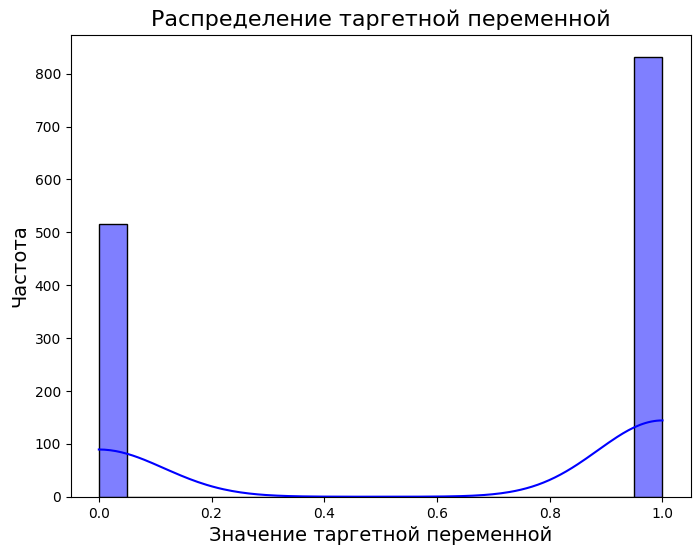

In [ ]:
# Преобразуем данные в Pandas Series
import seaborn as sns
target_series = pd.Series(y)

# Построим график распределения
plt.figure(figsize=(8, 6))
sns.histplot(target_series, kde=True, color='blue', bins=20)

# Настройки графика
plt.title('Распределение таргетной переменной', fontsize=16)
plt.xlabel('Значение таргетной переменной', fontsize=14)
plt.ylabel('Частота', fontsize=14)

# Отображение графика
plt.show()

In [ ]:
X = X.fillna(0)

In [ ]:
X = create_feature_importances(X, y)

Изначальное количество признаков: 202
Количество отобранных признаков: 84


In [ ]:
X.reset_index(inplace=True, drop=True)

In [ ]:
def generate_AVfpts(data):
    Avalon_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon_fpts.append(avfpts)
    return pd.DataFrame(np.array(Avalon_fpts))
Avalon_fpts = generate_AVfpts(df['Canonical Smiles'])
Avalon_fpts

100%|██████████| 1347/1347 [00:01<00:00, 755.41it/s]


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,1,0,0,0,0,0,1,0,1,...,1,1,0,0,0,0,0,1,0,0
2,0,0,0,0,1,1,1,1,1,1,...,1,0,1,0,0,1,0,0,1,1
3,0,1,0,1,0,1,1,1,0,1,...,1,1,1,0,0,1,0,0,1,1
4,0,0,0,1,0,0,1,1,0,1,...,0,1,1,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1
1343,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1
1344,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1
1345,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1


In [ ]:
X_new = pd.concat([X, Avalon_fpts], axis=1)
X_new.columns = X_new.columns.astype(str)

In [ ]:
X_new.to_csv('DISL_Tyrosine_class_X.csv')
y.to_csv('DISL_Tyrosine_class_y.csv')

In [ ]:
y

,Blinding
3,1
5,1
7,1
8,1
10,1
...,...
4246,1
4257,1
4259,1
4264,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(X_new))

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)
def create_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    plt.plot(y_test, y_test, 'r')
    plt.scatter(y_test, y_pred)
    plt.show()
    print('f1:', f1)
    print('acc:', acc)
    print("Recall:", recall)
    print("precision:", precision)
    return model, f1, acc, recall, precision

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR
from catboost import CatBoostClassifier
model, f1, acc, recall, precision = create_model(CatBoostClassifier())

Learning rate set to 0.010634
0:	learn: 0.6862299	total: 25ms	remaining: 24.9s
1:	learn: 0.6806490	total: 50.7ms	remaining: 25.3s
2:	learn: 0.6743733	total: 75.8ms	remaining: 25.2s
3:	learn: 0.6682936	total: 100ms	remaining: 25s
4:	learn: 0.6617346	total: 125ms	remaining: 24.9s
5:	learn: 0.6551905	total: 150ms	remaining: 24.8s
6:	learn: 0.6490110	total: 174ms	remaining: 24.7s
7:	learn: 0.6433760	total: 202ms	remaining: 25.1s
8:	learn: 0.6369658	total: 227ms	remaining: 25s
9:	learn: 0.6314750	total: 253ms	remaining: 25s
10:	learn: 0.6262331	total: 279ms	remaining: 25.1s
11:	learn: 0.6207708	total: 304ms	remaining: 25s
12:	learn: 0.6149273	total: 329ms	remaining: 24.9s
13:	learn: 0.6092250	total: 354ms	remaining: 24.9s
14:	learn: 0.6035247	total: 383ms	remaining: 25.1s
15:	learn: 0.5986892	total: 412ms	remaining: 25.3s
16:	learn: 0.5939255	total: 437ms	remaining: 25.3s
17:	learn: 0.5891592	total: 462ms	remaining: 25.2s
18:	learn: 0.5843901	total: 487ms	remaining: 25.2s
19:	learn: 0.57996